# Part 1: Create database set
By inputting a target gene, a nested dictionary will be created, with each key being the name of a cancer and each value being a dictionary containing the genomic, proteomic, transcriptomic, and phosphoproteomic data. In other words, the dictionary will be:

{
    cancer : {   
    
            "gen" : <cancer's genomic data>,
            "prot" : <cancer's proteomic data>,
            "trans": <cancer's transcriptomic data>,
            "phos": <cancer's phosphoproteomic data>
        }
    ... for each cancer
}

In [1]:
import cptac
import cptac.pancan as pc
import numpy as np
import cptac.utils as ut
import plot_utils as plt_ut
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset_names = pc.list_datasets(False)
dataset_names  = dataset_names.split('\n')
dataset_names

['PancanBrca',
 'PancanCcrcc',
 'PancanCoad',
 'PancanGbm',
 'PancanHnscc',
 'PancanLscc',
 'PancanLuad',
 'PancanOv',
 'PancanUcec',
 'PancanPdac']

In [4]:
target_gene = "TP53"

In [5]:
# List of pathways to select for the trans analysis
paths = ut.get_pathways_with_proteins(proteins = target_gene, database = 'wikipathways')
paths

,id,pathway
0,TP53,MAPK Signaling Pathway
1,TP53,DNA Damage Response
2,TP53,Wnt Signaling Pathway and Pluripotency
3,TP53,Pathways Affected in Adenoid Cystic Carcinoma
4,TP53,Retinoblastoma Gene in Cancer
5,TP53,Mammary gland development pathway - Involution...
6,TP53,miRNA regulation of p53 pathway in prostate ca...
7,TP53,miRNA Regulation of DNA Damage Response
8,TP53,Ultraconserved region 339 modulation of tumor ...
9,TP53,Gastric Cancer Network 2


In [6]:
# Indicate the NUMERICAL INDICES of the pathways of interest
path_indices=[0,1,2,10,18]

In [9]:
datasets = {}
for name in dataset_names:
    exec(f"cancer = pc.{name}(no_internet = True)")  
    genotype_data = cancer.get_genotype_all_vars(target_gene, omics_source = "washu")
    
    proteomic_data = cancer.get_proteomics(source = 'umich')
    proteomic_data = proteomic_data.droplevel("Database_ID", axis = 1)
    
    phospho_data = cancer.get_phosphoproteomics(source = 'umich')
    phospho_data = phospho_data.droplevel("Database_ID", axis = 1).droplevel("Peptide", axis = 1)
    
    transcript_data = cancer.get_transcriptomics(source = "washu")
    transcript_data = transcript_data.droplevel("Database_ID", axis = 1)
    
    datasets[name[6:]] = {
                        "gen" : genotype_data,
                        "prot": proteomic_data,
                        "trans": transcript_data,
                        "phos" : phospho_data
                         }    
    print(f"Loaded {name}...")

Loaded PancanBrca...                
Loaded PancanCcrcc...                    
Loaded PancanCoad...                
Loaded PancanGbm...                   
Loaded PancanHnscc...                    
Loaded PancanLscc...                    
Loaded PancanLuad...                    
Loaded PancanOv...                 
Loaded PancanUcec...                    
Loaded PancanPdac...                    


In [ ]:
#DELETE THIS CELL
#I use this to let me know when the data has finished loading haha
# import webbrowser
# webbrowser.open("https://www.youtube.com/watch?v=dQw4w9WgXcQ")

# Part 2: Select mutations
Determine which cancers have mutation types with rates above 20%.

To facilitate that, the mutation types from the get_genotype_all_vars must be grouped into functional types.


In [10]:
mutation_types = ["Deletion", "Amplification", "Truncation", "Indel", "Missense"]

In [11]:
# Grouping the mutation types for each cancer
for name, dataset in datasets.items():
    genotypes = dataset["gen"]
    genotypes.replace(["Nonsense_Mutation", "Frame_Shift_Ins", "Frame_Shift_Del"], "Truncation", inplace = True)
    genotypes.replace(["In_Frame_Del", "In_Frame_Ins"], "Indel", inplace = True)
    genotypes.replace(["Missense_Mutation", "Wildtype_Tumor"], ["Missense", "Wildtype"], inplace = True)
    genotypes = genotypes.loc[~genotypes["Mutation"].isin(["Intron","Silent"])]
    datasets[name]["gen"] = genotypes

In [ ]:
# Create a bargraph displaying the mutation types

In [12]:
# Determine which cancers have mutation rates over 20%
variants_to_analyze = {}
for name, dataset in datasets.items():
    mut_type_freq = dataset["gen"]["Mutation"].value_counts() / len(dataset["gen"])
    
    mut_type_freq = mut_type_freq.loc[mut_type_freq >= 0.2]
    variants_to_analyze[name] = set(mut_type_freq.index.tolist())
    variants_to_analyze[name].discard("Wildtype")
print(str(variants_to_analyze))

{'Brca': {'Deletion'}, 'Ccrcc': set(), 'Coad': {'Deletion'}, 'Gbm': set(), 'Hnscc': {'Missense', 'Truncation'}, 'Lscc': {'Missense', 'Deletion'}, 'Luad': {'Missense', 'Deletion'}, 'Ov': {'Missense', 'Deletion'}, 'Ucec': set(), 'Pdac': {'Missense', 'Deletion'}}


In [ ]:
# plt.figure1_plot_mutations(datasets.values(), list(datasets.keys()), save_to_path = "Test_Figure.png")

# Part 3: Cis effects
Determines which genes that, given a mutation, will change the expression in their own proteomics, transcriptomics, or phosphoproteomics.This analysis is repeated for every cancer, and every mutation type.

Writes out a file containing the infomation for each mutation and cancer, and creates boxplot summarizing the data

In [13]:
from scipy.stats import ttest_ind
omics_key = {"prot":"proteomics", "trans":"transcriptomics","phos":"phosphoproteomics"}

In [14]:
'''
Parameters
pval_symbol: String. The symbol associated with the significance of the pvalue (NS, *, **, or ***)
x1, x2: Float. x coordinates for the start and end of the annotation line.
line_start: Float. y coordinate for the horizontal line (Default = .05).
line_height: Float. The height of the vertical lines at the start and end of the horizontal line (Default = .05).

Returns a formated annotation line showing the significance symbol of each pvalue.
'''
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

In [41]:
def generate_cis_plot(boxplot_data, omics_type, pval_df):
    plt.rcParams['figure.figsize'] = (15,10) # size of plot
#     if len(gene_list) > 15:
#         plt.rcParams['figure.figsize']=(20,10)
    sns.set(font_scale = 1.2, style = "white")

    for site in boxplot_data["site"].unique():
        mutations = sorted(boxplot_data["Mutation"].unique(), reverse = True)
        boxplot = sns.boxplot(x = "cancer_type", y = site, hue = "Mutation", showfliers = False, 
                              data = boxplot_data[boxplot_data["site"] == site], hue_order = mutations)
        boxplot = sns.stripplot(x = "cancer_type", y = site, hue = "Mutation", jitter = True, hue_order = mutations,
                               color = ".3", dodge = True, data = boxplot_data[boxplot_data["site"] == site])
        gene_site = site if site == target_gene else target_gene+'.'+site
        boxplot.set(xlabel = "", ylabel = f"{gene_site}_{omics_key[omics_type]}")
        boxplot.set(title = f"Pancan Analysis of {gene_site} {omics_key[omics_type].capitalize()} Mutations")
#         if len(gene_list) > 15:
#             boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=50)
        
        num = len(boxplot_data["Mutation"].unique())
        handles, labels = boxplot.get_legend_handles_labels()
        legend = plt.legend(handles[0:num], labels[0:num], loc = "lower right")
        
        ## CREATE PVAL ANNOTATIONS
        symbols = {}
        start = -0.3
        cancer_list = boxplot.get_xticklabels() # get a list of cancer types actually plotted 
        first_mutation = mutations[1]
        bottom,top = plt.ylim()
        annot_size = top + 0.5
        annot_scale = (top - bottom) * 0.05 # sets annotation height between mutations based on y-axis scale
        for cancer in cancer_list:
            cancer = cancer.get_text()
            mutation_list = sorted(boxplot_data.loc[boxplot_data["cancer_type"] == cancer]["Mutation"].unique().tolist(),
                                   reverse = True)
            mutation_list.remove("Wildtype")
            offset = 0.4
            annot_offset = annot_scale
            for mutation in mutation_list:
                pval = pval_df.loc[(pval_df["Cancer"] == cancer)&(pval_df["Mutation"] == mutation)&
                                   (pval_df["Site"] == site)]['P_Value']
                if pval.tolist():
                    pval = pval.tolist()[0]
                    if pval  <= 0.001:
                         symbols[cancer] = '***'
                    elif pval  <= 0.01:
                        symbols[cancer] = '**'  
                    elif pval <= 0.05:
                        symbols[cancer] = '*'
                    else:
                        symbols[cancer] = 'ns'
                    if mutation == first_mutation:
                        format_pval_annotation(symbols[cancer], start, start + 0.2, annot_size)
                    else:
                        format_pval_annotation(symbols[cancer], start, start + offset, annot_size + annot_offset)
                        offset += 0.2
                        annot_offset += annot_scale
            start += 1
        
        plt.show()
        plt.clf()
        plt.close()
            
#         fig = boxplot.get_figure()
#         fig.savefig(f"Cis_Effect_output/Test_{gene_site}_{omics_key[omics_type]}.png")
#         fig.clf()

In [16]:
# Create a function that will analyze the protein cis effects for a given mutation type
def analyze_cis_mutation(omics_type, write_out = True, output_boxplot = True):
    """Analyzes the cis effects for a given mutation type across all cancers.
    
    Parameters:
    omics_type (str): The omics to analyze. Possible values are in list ["prot", "trans", "phos"]
    write_out (bool, optional): Whether to write out the data to a separate file.
    
    Returns the output of scipy.ttest_ind() between "Wildtype" and mutation_type tumors. If analyzing phosphoproteomics, returns a list of such outputs
    """
    if write_out:
        # Clears the target file
        file_name = f"Cis_Effect_output/{omics_key[omics_type].capitalize()}_Analysis_cis.txt"
        with open(file_name, 'w') as out_file: pass
                
    result = []
    pval_dict = {'Cancer':[], 'Mutation':[], 'Site':[], 'P_Value':[]}
    boxplot_data = []
    for cancer_type, dataset in datasets.items():
        if write_out:
            with open(file_name, 'a') as out_file:
                out_file.write(cancer_type.upper()+'\n')
            
        for mutation_type in mutation_types:
            ## PREPARE DATA ##
            if mutation_type not in variants_to_analyze[cancer_type]: 
                continue
#             print(f"{cancer_type} {mutation_type}s") #debug temp
            genotype_and_omic = pd.merge(dataset["gen"]["Mutation"], dataset[omics_type][target_gene], left_index = True,
                                         right_index = True)
            genotype_and_omic = genotype_and_omic.loc[genotype_and_omic["Mutation"].isin(["Wildtype", mutation_type])]
                            
            for site in genotype_and_omic.drop("Mutation", axis = 1).columns:
                ## ANALYZE P-VALUES ##
                try:
                    pval = ut.wrap_ttest(genotype_and_omic, label_column="Mutation", comparison_columns=[site],
                                         correction_method = "fdr_bh", return_all=True).iloc[0,1]
                except:
                    continue
                pval_dict['Cancer'].append(cancer_type)
                pval_dict['Mutation'].append(mutation_type)
                pval_dict['Site'].append(site)
                pval_dict['P_Value'].append(pval)
                
                result.append ({
                    "omics_type":omics_type,
                    "site":site,
                    "mutation_type":mutation_type,
                    "cancer_type":cancer_type,
                    "pval":pval
                })
                    
                ## GATHER DATA FOR BOXPLOT ##
                if output_boxplot:
                    new_data = genotype_and_omic[(genotype_and_omic["Mutation"] == mutation_type)|
                                                (genotype_and_omic["Mutation"] == "Wildtype")]
                    new_data["site"], new_data["cancer_type"] = site, cancer_type
                    boxplot_data.append(pd.DataFrame(new_data))
                
                ## WRITE OUT RESULT ##
                if write_out:
                    with open(file_name, 'a') as out_file: 
                        out_file.write(f"   {mutation_type} p-val: {pval}\n")
    
    ## CREATE BOXPLOT ##
    if output_boxplot:
        pval_df = pd.DataFrame(pval_dict)
        boxplot_data = pd.concat(boxplot_data)
        generate_cis_plot(boxplot_data, omics_type, pval_df) 
        
    result = pd.DataFrame(result)
    return result

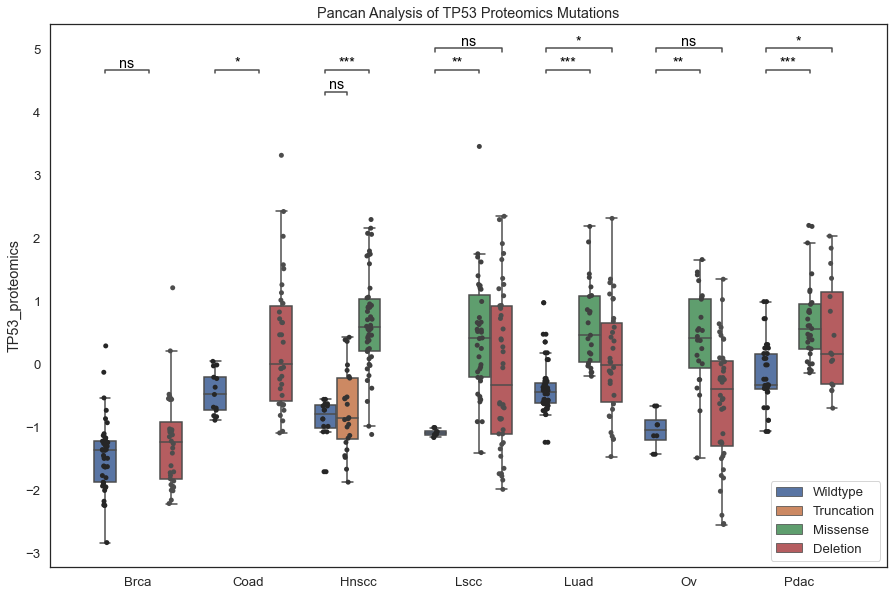

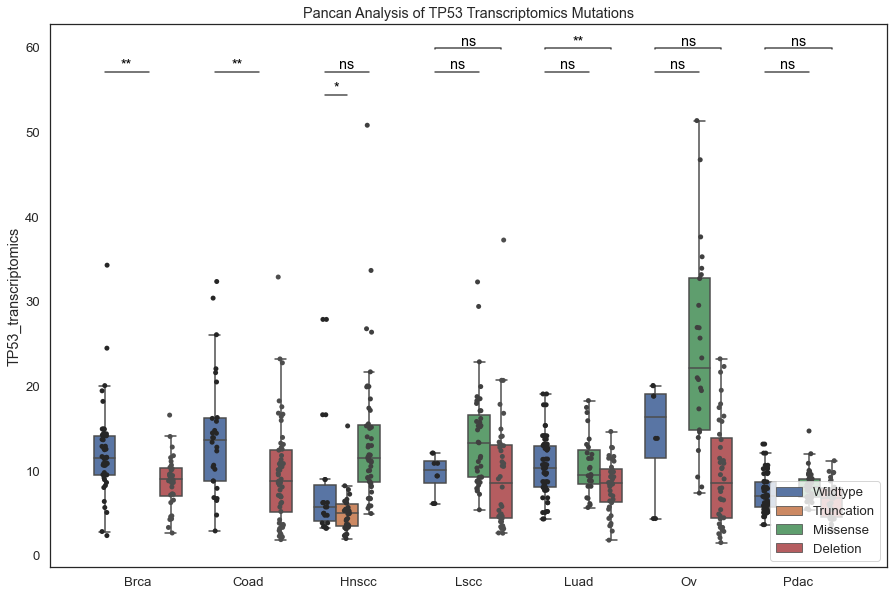

Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!


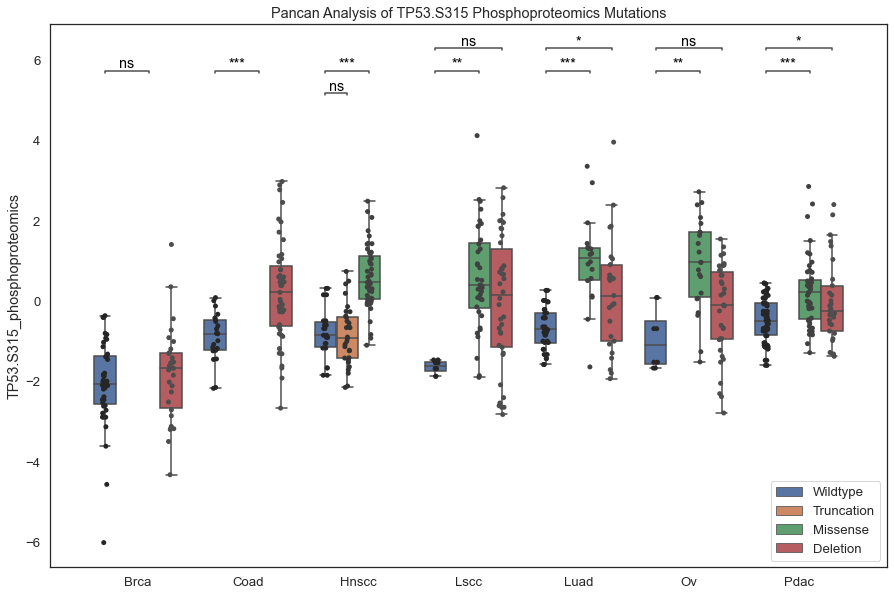

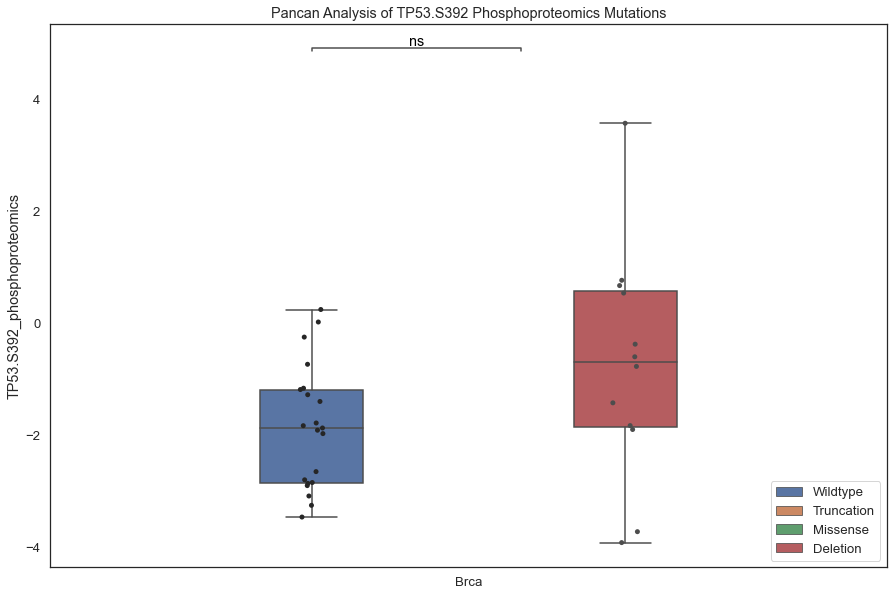

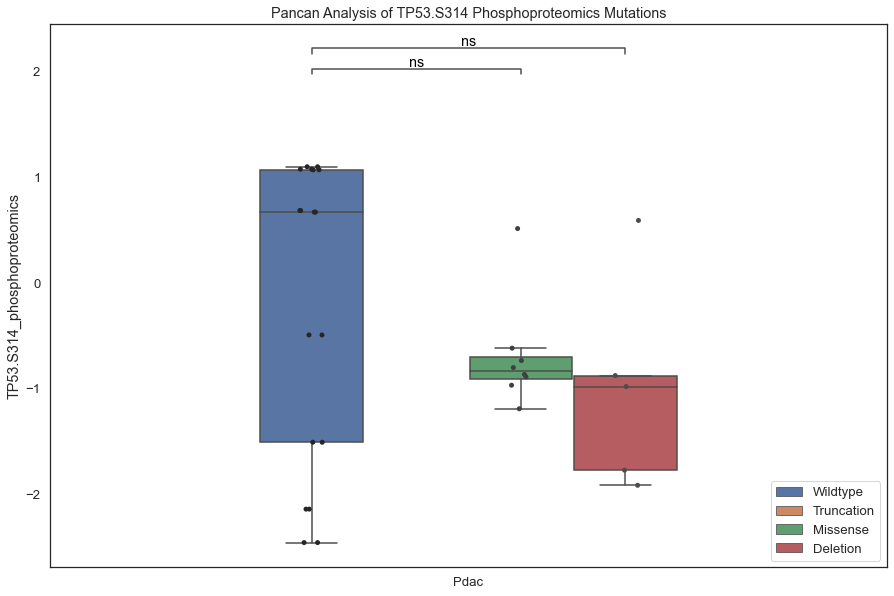

,omics_type,site,mutation_type,cancer_type,pval
0,prot,TP53,Deletion,Brca,1.290286e-01
1,prot,TP53,Deletion,Coad,1.428251e-02
2,prot,TP53,Truncation,Hnscc,4.883127e-01
3,prot,TP53,Missense,Hnscc,1.459365e-06
4,prot,TP53,Deletion,Lscc,1.266779e-01
5,prot,TP53,Missense,Lscc,2.513199e-03
6,prot,TP53,Deletion,Luad,1.920592e-02
7,prot,TP53,Missense,Luad,7.294556e-08
8,prot,TP53,Deletion,Ov,3.607840e-01
9,prot,TP53,Missense,Ov,1.134810e-03


In [42]:
pd.concat([analyze_cis_mutation(omics_type) for omics_type in ["prot", "trans", "phos"]], output_boxplot=False)

# Part 4: Trans Effects
Determines which genes that, given a mutation, will change the expression in another protein's proteomics, transcriptomics, or phosphoproteomics.This analysis is repeated for every cancer, and every mutation type.

To reduce the computational intensity and the corrections needed, the scope will be restricted to genes that share specific pathways with the target gene. These pathways are hypothesized to be significant in the gene's function, and **must be specificed beforehand**, either at the beginning of this notebook or in the following cells.

The analysis will then be repeated for all genes in the dataset. As the number of comparisons is greater, the correction applied will be more substantial.

Writes out a file containing the infomation for each mutation and cancer, and creates boxplot summarizing the data

In [ ]:
if path_indices == []:
    print(paths)
    path_indices = []

In [ ]:
interacting_proteins = ut.get_proteins_in_pathways(paths["pathway"].loc[path_indices], database = 'wikipathways')
interacting_proteins = set(interacting_proteins["member"])

# genes_measured = [gene for dataset in datasets.values() for gene in dataset["prot"].columns]
genes_measured = set([gene for gene in dataset["prot"].columns for dataset in datasets.values()])
genes_to_analyze = sorted([protein for protein in interacting_proteins if protein in genes_measured])
temp_genes = sorted([protein for protein in interacting_proteins if protein not in genes_measured])

if target_gene in new_genes:new_genes.remove(target_gene)
print(f"Interacting genes: {len(interacting_proteins)}")
print(f"Not measured in cptac: {len(temp_genes)}")
print(f"Genes to analyze: {len(new_genes)}")

In [ ]:
# NOT YET READY FOR PHOSPHO DATA!!! #
def analyze_trans_mutation(omics_type, genes_to_analyze = None, write_out = True, create_boxplot = True):
    result = []
    for cancer_type, dataset in datasets.items():
        genes_to_analyze = genes_to_analyze if genes_to_analyze is not None else list(dataset[omics_type].columns)
        for mutation_type in mutation_types:
            if mutation_type not in variants_to_analyze[cancer_type]: continue
                
            print(f"{omics_key[omics_type]} {cancer_type} {mutation_type}s") #debug temp
            genotype_and_omic = pd.merge(dataset["gen"]["Mutation"], dataset[omics_type], left_index = True, right_index = True)
            genotype_and_omic = genotype_and_omic.loc[genotype_and_omic["Mutation"].isin(["Wildtype", mutation_type])]
            
#             return genotype_and_omic
                            
            for gene in genotype_and_omic.drop("Mutation", axis = 1).columns:
                ## ANALYZE P-VALUES ##
                ut.wrap_ttest()
                pval = ut.wrap_ttest(genotype_and_omic, label_column="Mutation", return_all=True).iloc[0,1]
                result.append ({
                    "omics_type":omics_type,
                    "site":site,
                    "mutation_type":mutation_type,
                    "cancer_type":cancer_type,
                    "pval":pval
                })
    return result
                              
            
            
            
            
            
            
            
            
            
            

                


In [ ]:
analyze_trans_mutation("prot")

In [ ]:
#     result = []
#     boxplot_data = []
#     for cancer_type, dataset in datasets.items():
            
#         for mutation_type in mutation_types:
#             ## PREPARE DATA ##
#             if mutation_type not in variants_to_analyze[cancer_type]: 
#                 continue
#             print(f"{omics_key[omics_type]} {cancer_type} {mutation_type}s") #debug temp
#             genotype_and_omic = pd.merge(dataset["gen"]["Mutation"], dataset[omics_type][target_gene], left_index = True, right_index = True)
#             genotype_and_omic = genotype_and_omic.loc[genotype_and_omic["Mutation"].isin(["Wildtype", mutation_type])]
                            
#             for site in genotype_and_omic.drop("Mutation", axis = 1).columns:
#                 ## ANALYZE P-VALUES ##
#                 try:
#                     pval = ut.wrap_ttest(genotype_and_omic, label_column="Mutation", comparison_columns=[site], return_all=True).iloc[0,1]
#                 except:
#                     continue
#                 result.append ({
#                     "omics_type":omics_type,
#                     "site":site,
#                     "mutation_type":mutation_type,
#                     "cancer_type":cancer_type,
#                     "pval":pval
#                 })
                    
#                 ## GATHER DATA FOR BOXPLOT ##
#                 if output_boxplot:
#                     new_data = genotype_and_omic[genotype_and_omic["Mutation"] == mutation_type]
#                     new_data["site"], new_data["cancer_type"] = site, cancer_type
#                     boxplot_data.append(pd.DataFrame(new_data))
                
#                 ## WRITE OUT RESULT ##
#                 if write_out:
#                     with open(file_name, 'a') as out_file: 
#                         out_file.write(f"   {mutation_type} p-val: {pval}\n")
    
#     ## CREATE BOXPLOT ##
#     if output_boxplot:
#         boxplot_data = pd.concat(boxplot_data)
#         generate_cis_plot(boxplot_data, omics_type)
                
#     result = pd.DataFrame(result)
#     return result

# def generate_cis_plot(boxplot_data, omics_type):
#     sns.set_theme(style="whitegrid")
#     for site in boxplot_data["site"]:
#         plot = sns.boxplot(x = "Mutation", y = site, hue = "cancer_type", data = boxplot_data[boxplot_data["site"] == site])
#         gene_site = site if site == target_gene else target_gene+'.'+site
#         plot.set(ylabel=f"{gene_site} Mutations")
#         plot.get_figure().savefig(f"Cis_Effect_output/{gene_site}_{omics_key[omics_type]}.png")
#         plot.get_figure().clf()
# #     plt = sns.stripplot(x = "Mutation", y = target_gene, hue = "cancer_type", data = boxplot_data, color = "0")
            

In [ ]:
# # Create a function that will analyze the protein cis effects for a given mutation type
# def analyze_trans_mutation(omics_type, mutation_type, gene_list, write_out = True, pval_only = True):
#     """Analyzes the trans effects for a given mutation type across all cancers.
    
#     Parameters:
#     mutation_type (str): The mutation type to analyze, as a string. Possible values given in mutation_types.
#     omics_type (str): The omics to analyze. Possible values are in list ["prot", "trans", "phos"]
#     gene_list (list[str]): A list of genes with proteins in the same pathway as those from target_gene
#     write_out (bool, optional): Whether to write out the data to a separate file.
#     pval_only (bool, optional): If write_out, only writes out the p_value for each analysis. If not write_out, has no effect.
    
#     Returns a list of the outputs of scipy.ttest_ind() between "Wildtype" and mutation_type tumors, for each of the genes. If analyzing phosphoproteomics, returns a list of lists, in the form [[(site_name, pval) for each site] for each entry]
#     """
#     if write_out:
#         # Clears the target file
#         file_name = omics_key[omics_type].capitalize() + '_' + mutation_type.capitalize() + 's.txt'
#         with open("Trans_Effect_output/" + file_name, 'w') as out_file: pass
#     for name, dataset in datasets.items():
#         if mutation_type not in variants_to_analyze[name]: continue
        
#         # Separate the wildtype and mutated samples
#         genotype_and_omic = pd.merge(dataset["gen"], dataset[omics_type], left_index = True, right_index = True)
#         mutation = genotype_and_omic.loc[genotype_and_omic["Mutation"] == mutation_type].dropna()
#         wildtype = genotype_and_omic.loc[genotype_and_omic["Mutation"] == "Wildtype"].dropna()
        
#         # Phosphoproteomics must be analyzed at each site in the gene
#         if omics_type != "phos":
#             result = [ttest_ind(mutation[trans_gene].dropna(), wildtype[trans_gene].dropna())[1] for trans_gene in gene_list]
#         else:
#             result = [(site, ttest_ind(mutation[trans_gene][site].dropna(), wildtype[trans_gene][site])[1]) for site in trans_gene for trans_gene in mutation.columns if site in wildtype[trans_gene].columns]
                
#         if write_out:
#             output_string = ""
#             if not pval_only:
#                 output_string += f"{name}\n"
#                 output_string += f"Number of {mutation_type}s = {len(mutation)}\n"
#                 output_string += f"Number of Wildtypes = {len(wildtype)}\n"
#             if omics_type != "phos":
#                 output_string += f"{name} {mutation_type} P-value = {result}\n\n"
#             else:
#                 output_string += f"{name} {mutation_type} P-values:\n"
#                 for site in result:
#                     output_string += f"   {site[0]}: {site[1]}\n"
#                 ouput_string += '\n'
#             with open("Trans_Effect_output/" + file_name, "a") as out_file:
#                 print(output_string)
#                 out_file.write("output_string") 
                
#     try:
#         return result
#     except UnboundLocalError:
#         return

    

In [ ]:
#Now, run the analysis for every mutation_type, for every omics_type
for omics_type in ["prot", "trans", "phos"]:
    for mutation_type in mutation_types:
        analyze_trans_mutation(omics_type, mutation_type, new_genes, write_out = True, pval_only = False)

In [ ]:
with open("deletion_trans_data.txt", 'w') as outFile:
    all_significant = {}
    for name, dataset in datasets.items():
        if name not in deletion_sets: continue
        print(name + '\n')
        outFile.write(name + '\n')
        significant_changes = {}
        for trans_gene in interacting_proteins:
            genotype_and_prot = dataset[0].merge(dataset[1], left_index = True, right_index = True)
            if trans_gene not in genotype_and_prot: continue
            deletions = genotype_and_prot.loc[genotype_and_prot["Mutation"] == "Deletion"][trans_gene].dropna()
            wildtypes = genotype_and_prot.loc[genotype_and_prot["Mutation"] == "Wildtype_Tumor"][trans_gene].dropna()
            result = ttest_ind(deletions, wildtypes)
            print(trans_gene + " P-value with " + name + " deletion: " + str(result[1]))
            outFile.write(name + " deletion P-value: " + str(result[1]))
        print('\n')
        outFile.write('\n')
